# Install Environment

In [1]:
!pip install datasets
!pip install transformers[torch]

import os
import pandas as pd
import torch
import transformers as tr
from datasets import Dataset, load_metric
from sklearn.model_selection import train_test_split
import numpy as np
from transformers import Trainer
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.4/261.4 kB 6.0 MB/s eta 0:00:00


# Data Importing

In [2]:
def read_data():
    # GonzaloA data
    gonzaloa_train = pd.read_csv(
        "https://github.com/AnasElbattra/News-Understanding-NLP/raw/main/FAKE-REAL/DATA/GonzaloA_fake_news/train.csv"
    )  # 20000 row      0 = fake, 1 = real

    gonzaloa_test = pd.read_csv(
        "https://github.com/AnasElbattra/News-Understanding-NLP/raw/main/FAKE-REAL/DATA/GonzaloA_fake_news/test.csv"
    )  # 6284 row    0 = fake, 1 = real

    # ErfanMoosaviMonzzah
    Erfan_train = pd.read_csv(
        "https://github.com/AnasElbattra/News-Understanding-NLP/raw/main/FAKE-REAL/DATA/ErfanMoosaviMonazzah/train.csv"
    )  # 20000 row      0 = fake, 1 = real

    Erfan_test = pd.read_csv(
        "https://github.com/AnasElbattra/News-Understanding-NLP/raw/main/FAKE-REAL/DATA/ErfanMoosaviMonazzah/test.csv"
    )  # 18254 row      0 = fake, 1 = real

    # IFND
    IFND_train = pd.read_csv(
        "https://github.com/AnasElbattra/News-Understanding-NLP/raw/main/FAKE-REAL/DATA/IFND/train.csv"
    )  # 20000 row      0 = fake, 1 = real

    IFND_test = pd.read_csv(
        "https://github.com/AnasElbattra/News-Understanding-NLP/raw/main/FAKE-REAL/DATA/IFND/test.csv"
    )  # 36340 row      0 = fake, 1 = real

    # kaggle_datafake
    kaggle_train = pd.read_csv(
        "https://github.com/AnasElbattra/News-Understanding-NLP/raw/main/FAKE-REAL/DATA/kaggle_datafake/train.csv"
    )  # 20000 row      0 = fake, 1 = real

    kaggle_test = pd.read_csv(
        "https://github.com/AnasElbattra/News-Understanding-NLP/raw/main/FAKE-REAL/DATA/kaggle_datafake/test.csv"
    )  # 251065 row     0 = fake, 1 = real

    # pushpdeepfake_news_combined
    pushpdeepfake_train = pd.read_csv(
        "https://github.com/AnasElbattra/News-Understanding-NLP/raw/main/FAKE-REAL/DATA/pushpdeepfake_news_combined/train.csv"
    )  # 20000 row      0 = fake, 1 = real

    pushpdeepfake_test = pd.read_csv(
        "https://github.com/AnasElbattra/News-Understanding-NLP/raw/main/FAKE-REAL/DATA/pushpdeepfake_news_combined/test.csv"
    )  # 19094 row      0 = fake, 1 = real

    FAKES = pd.read_csv(
        "https://github.com/AnasElbattra/News-Understanding-NLP/raw/main/FAKE-REAL/DATA/FA-KES-Dataset.csv"
    )  # 804 row      0 = fake, 1 = real
    FAKES = FAKES[["text", "label"]]

    # news_articles
    news_articles = pd.read_csv(
        "https://github.com/AnasElbattra/News-Understanding-NLP/raw/main/FAKE-REAL/DATA/news_articles.csv"
    )  # 2046 row       0 = fake, 1 = real
    news_articles = news_articles[["text", "label"]]

    news_articles_cleaned = pd.read_csv(
        "https://github.com/AnasElbattra/News-Understanding-NLP/raw/main/FAKE-REAL/DATA/news_articles_cleaned.csv"
    )  # 1660 row       0 = fake, 1 = real
    news_articles_cleaned = news_articles_cleaned[["text", "label"]]

    news_articles_source = pd.read_csv(
        "https://github.com/AnasElbattra/News-Understanding-NLP/raw/main/FAKE-REAL/DATA/news_articles_source.csv"
    )  # 2050 row      0 = fake, 1 = real
    news_articles_source = news_articles_source[["text", "label"]]

    return (
        gonzaloa_train,
        gonzaloa_test,
        Erfan_train,
        Erfan_test,
        IFND_train,
        IFND_test,
        kaggle_train,
        kaggle_test,
        pushpdeepfake_train,
        pushpdeepfake_test,
        FAKES,
        news_articles,
        news_articles_cleaned,
        news_articles_source,
    )

In [3]:
(
    gonzaloa_train,
    gonzaloa_test,
    Erfan_train,
    Erfan_test,
    IFND_train,
    IFND_test,
    kaggle_train,
    kaggle_test,
    pushpdeepfake_train,
    pushpdeepfake_test,
    FAKES,
    news_articles,
    news_articles_cleaned,
    news_articles_source,
) = read_data()

# First Trial

## Data Combination

In [4]:
training_data = Erfan_train

dataset = Dataset.from_pandas(training_data)
dataset = dataset.train_test_split(test_size=0.2)
# dataset["train"]["label"]

## Fine Tuning


In [5]:
def to_tokens(tokenizer, label_map):
    def apply(x):
        target_labels = [label_map[y] for y in x["label"]]
        token_res = tokenizer(
            x["text"],
            text_target=target_labels,
            return_tensors="pt",
            truncation=True,
            padding=True,
        )
        return token_res

    return apply

In [6]:
tokenizer = tr.AutoTokenizer.from_pretrained("t5-small")

tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

In [7]:
label_lookup = {0: "fake", 1: "real"}
to_tokens = to_tokens(tokenizer, label_lookup)
tokenized_dataset = dataset.map(
    to_tokens, batched=True, remove_columns=["text", "label"]
)

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/4000 [00:00<?, ? examples/s]

In [8]:
local_training_root = "./"
checkpoint_name = "test-trainer"
local_checkpoint_path = os.path.join(local_training_root, checkpoint_name)
training_args = tr.TrainingArguments(
    local_checkpoint_path,
    num_train_epochs=1,  # default number of epochs to train is 3
    per_device_train_batch_size=16,
    optim="adamw_torch",
    report_to=["tensorboard"],
)

In [9]:
t5_model = tr.AutoModelForSeq2SeqLM.from_pretrained("t5-small")

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

In [10]:
metric = load_metric("accuracy")


def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = [
        tokenizer.decode(p, skip_special_tokens=True)
        for p in predictions.argmax(dim=-1)
    ]
    labels = [label_lookup[l] for l in labels]

    return metric.compute(predictions=predictions, references=labels)

<ipython-input-10-1bce426d05f6>:1: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")


In [11]:
trainer = Trainer(
    model=t5_model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    compute_metrics=compute_metrics,
)
trainer.train()

Step,Training Loss
500,0.562700
1000,0.008400


TrainOutput(global_step=1000, training_loss=0.2855326189994812, metrics={'train_runtime': 536.5299, 'train_samples_per_second': 29.821, 'train_steps_per_second': 1.864, 'total_flos': 2165468823552000.0, 'train_loss': 0.2855326189994812, 'epoch': 1.0})

In [12]:
# trainer.evaluate()
trainer.save_model()
trainer.save_state()
checkpoint_name = "test-trainer-deepspeed"
final_model_path = f"./llm04_fine_tuning/{checkpoint_name}"

trainer.save_model(output_dir=final_model_path)

fine_tuned_model = tr.AutoModelForSeq2SeqLM.from_pretrained(final_model_path)

## Evaluation

### Data Cleaning and sampling

In [13]:
def clean_sample(df, n):
    temp = df.groupby("label", group_keys=False).apply(lambda x: x.sample(n))
    temp = temp.sample(frac=1, random_state=42)
    temp.dropna(subset=["text", "label"], inplace=True)
    temp["label"].replace({0: "fake", 1: "real"}, inplace=True)
    return temp

In [14]:
def evaluate_data(df, n=50):
    temp = clean_sample(df, n)

    # Initialize an empty list to store the predictions
    predictions = []

    # Iterate through each row in the DataFrame
    for index, row in temp.iterrows():
        text = row["text"]
        news_report = [text]  # Create a list with the text from the DataFrame

        # Tokenize and generate predictions
        inputs = tokenizer(
            news_report, return_tensors="pt", truncation=True, padding=True
        )
        pred = fine_tuned_model.generate(
            input_ids=inputs["input_ids"], attention_mask=inputs["attention_mask"]
        )

        # Decode the predictions and store them in the predictions list
        classification = tokenizer.batch_decode(pred, skip_special_tokens=True)[0]
        predictions.append(classification)

    # Add the predictions to the DataFrame as a new column
    temp["predictions"] = predictions

    classification_rep = classification_report(temp["label"], temp["predictions"])
    print("Classification Report:")
    print(classification_rep)

    accuracy = accuracy_score(temp["label"], temp["predictions"])

    return accuracy

### Evaluation on the samples

In [15]:
gonzaloa_train_accuracy = evaluate_data(gonzaloa_train)

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Classification Report:
              precision    recall  f1-score   support

       enjoy       0.00      0.00      0.00         0
        fake       0.98      0.96      0.97        50
        real       0.98      0.98      0.98        50

    accuracy                           0.97       100
   macro avg       0.65      0.65      0.65       100
weighted avg       0.98      0.97      0.97       100



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [16]:
gonzaloa_test_accuracy = evaluate_data(gonzaloa_test)

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Classification Report:
              precision    recall  f1-score   support

        fake       1.00      0.92      0.96        50
        real       0.93      1.00      0.96        50

    accuracy                           0.96       100
   macro avg       0.96      0.96      0.96       100
weighted avg       0.96      0.96      0.96       100



In [17]:
Erfan_test_accuracy = evaluate_data(Erfan_test)

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Classification Report:
              precision    recall  f1-score   support

        fake       1.00      1.00      1.00        50
        real       1.00      1.00      1.00        50

    accuracy                           1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100



In [18]:
IFND_train_accuracy = evaluate_data(IFND_train)

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Classification Report:
              precision    recall  f1-score   support

        fake       0.53      1.00      0.69        50
        real       1.00      0.12      0.21        50

    accuracy                           0.56       100
   macro avg       0.77      0.56      0.45       100
weighted avg       0.77      0.56      0.45       100



In [19]:
IFND_test_accuracy = evaluate_data(IFND_test)

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Classification Report:
              precision    recall  f1-score   support

                   0.00      0.00      0.00         0
        fake       0.58      0.98      0.73        50
    negative       0.00      0.00      0.00         0
        real       0.93      0.26      0.41        50

    accuracy                           0.62       100
   macro avg       0.38      0.31      0.28       100
weighted avg       0.76      0.62      0.57       100



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [20]:
kaggle_train_accuracy = evaluate_data(kaggle_train)

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Classification Report:
              precision    recall  f1-score   support

        fake       0.55      0.12      0.20        50
        real       0.51      0.90      0.65        50

    accuracy                           0.51       100
   macro avg       0.53      0.51      0.42       100
weighted avg       0.53      0.51      0.42       100



In [21]:
kaggle_test_accuracy = evaluate_data(kaggle_test)

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Classification Report:
              precision    recall  f1-score   support

        fake       0.44      0.16      0.24        50
        real       0.49      0.80      0.61        50

    accuracy                           0.48       100
   macro avg       0.47      0.48      0.42       100
weighted avg       0.47      0.48      0.42       100



In [22]:
pushpdeepfake_train_accuracy = evaluate_data(pushpdeepfake_train)

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Classification Report:
              precision    recall  f1-score   support

        fake       0.96      1.00      0.98        50
        real       1.00      0.96      0.98        50

    accuracy                           0.98       100
   macro avg       0.98      0.98      0.98       100
weighted avg       0.98      0.98      0.98       100



In [23]:
pushpdeepfake_test_accuracy = evaluate_data(pushpdeepfake_test)

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Classification Report:
              precision    recall  f1-score   support

        fake       0.98      1.00      0.99        50
        real       1.00      0.98      0.99        50

    accuracy                           0.99       100
   macro avg       0.99      0.99      0.99       100
weighted avg       0.99      0.99      0.99       100



In [24]:
FAKES_accuracy = evaluate_data(FAKES)

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Classification Report:
              precision    recall  f1-score   support

        fake       0.20      0.02      0.04        50
        real       0.48      0.92      0.63        50

    accuracy                           0.47       100
   macro avg       0.34      0.47      0.34       100
weighted avg       0.34      0.47      0.34       100



In [25]:
news_articles_accuracy = evaluate_data(news_articles)

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Classification Report:
              precision    recall  f1-score   support

        fake       0.55      0.86      0.67        50
        real       0.68      0.30      0.42        50

    accuracy                           0.58       100
   macro avg       0.62      0.58      0.54       100
weighted avg       0.62      0.58      0.54       100



In [26]:
news_articles_cleaned_accuracy = evaluate_data(news_articles_cleaned)

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Classification Report:
              precision    recall  f1-score   support

        fake       0.57      0.80      0.67        50
        real       0.67      0.40      0.50        50

    accuracy                           0.60       100
   macro avg       0.62      0.60      0.58       100
weighted avg       0.62      0.60      0.58       100



In [27]:
news_articles_source_accuracy = evaluate_data(news_articles_source)

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Classification Report:
              precision    recall  f1-score   support

        fake       0.51      0.76      0.61        50
        real       0.54      0.28      0.37        50

    accuracy                           0.52       100
   macro avg       0.53      0.52      0.49       100
weighted avg       0.53      0.52      0.49       100



### Bar Chart

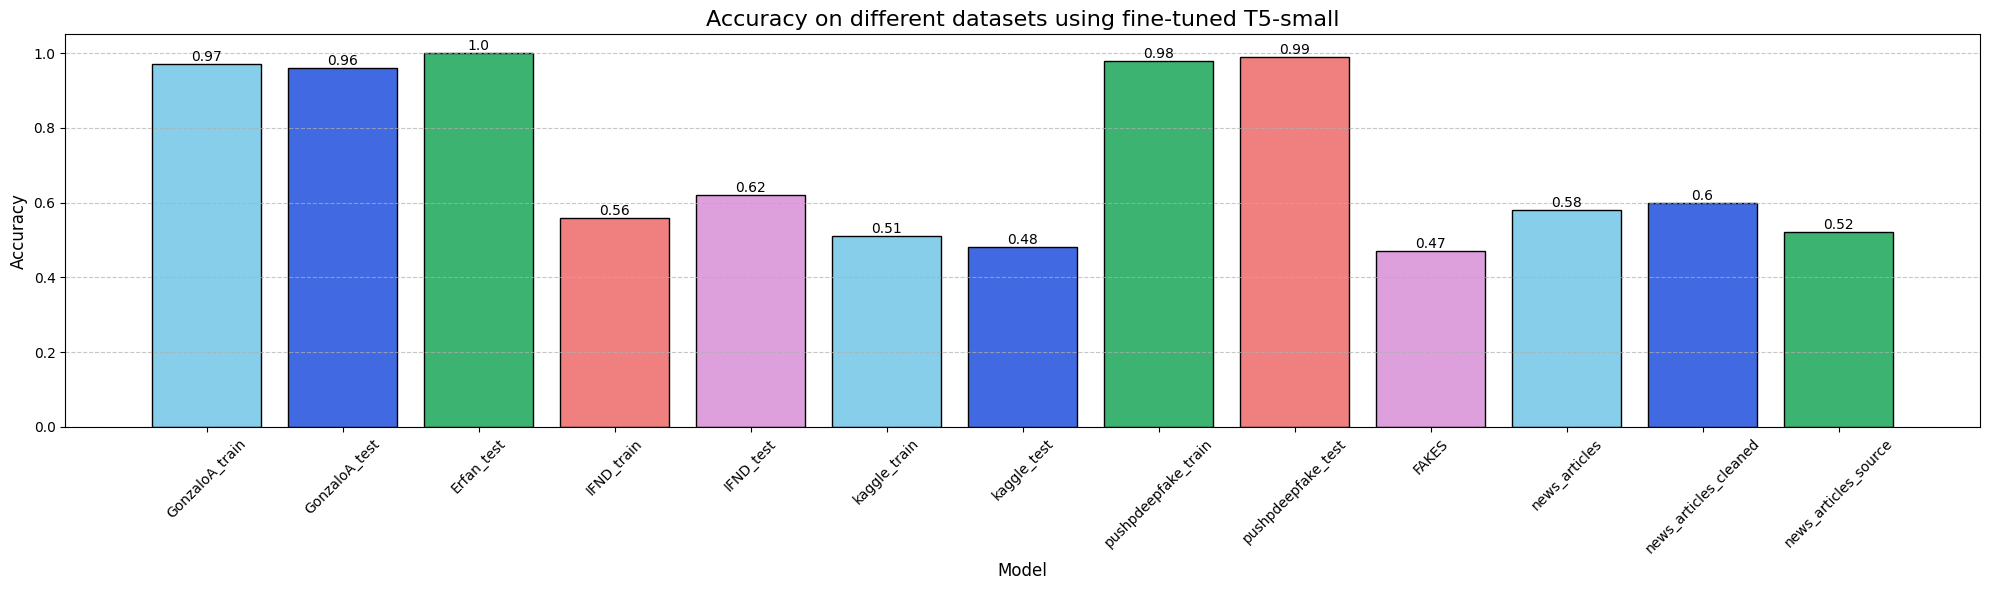

In [28]:
import matplotlib.pyplot as plt

# Model labels
models = [
    "GonzaloA_train",
    "GonzaloA_test",
    "Erfan_test",
    "IFND_train",
    "IFND_test",
    "kaggle_train",
    "kaggle_test",
    "pushpdeepfake_train",
    "pushpdeepfake_test",
    "FAKES",
    "news_articles",
    "news_articles_cleaned",
    "news_articles_source",
]

# Accuracy values
accuracies = [
    gonzaloa_train_accuracy,
    gonzaloa_test_accuracy,
    Erfan_test_accuracy,
    IFND_train_accuracy,
    IFND_test_accuracy,
    kaggle_train_accuracy,
    kaggle_test_accuracy,
    pushpdeepfake_train_accuracy,
    pushpdeepfake_test_accuracy,
    FAKES_accuracy,
    news_articles_accuracy,
    news_articles_cleaned_accuracy,
    news_articles_source_accuracy,
]

colors = [
    "skyblue",
    "royalblue",
    "mediumseagreen",
    "lightcoral",
    "plum",
    "skyblue",
    "royalblue",
    "mediumseagreen",
    "lightcoral",
    "plum",
    "skyblue",
    "royalblue",
    "mediumseagreen",
]

# Create the bar plot
plt.figure(figsize=(20, 6))
bars = plt.bar(models, accuracies, color=colors, edgecolor="black")

# Adding value labels on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        yval,
        round(yval, 2),
        va="bottom",
        ha="center",
    )

plt.title("Accuracy on different datasets using fine-tuned T5-small", fontsize=16)
plt.ylabel("Accuracy", fontsize=12)
plt.xlabel("Model", fontsize=12)
plt.xticks(rotation=45, fontsize=10)

# Adding a grid
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.tight_layout()
plt.show()

# Second Trial

### Data Importing

In [29]:
(
    gonzaloa_train,
    gonzaloa_test,
    Erfan_train,
    Erfan_test,
    IFND_train,
    IFND_test,
    kaggle_train,
    kaggle_test,
    pushpdeepfake_train,
    pushpdeepfake_test,
    FAKES,
    news_articles,
    news_articles_cleaned,
    news_articles_source,
) = read_data()

### Data Combination

In [30]:
training_data = pd.concat([kaggle_train, Erfan_train, IFND_train], ignore_index=True)


dataset = Dataset.from_pandas(training_data)
dataset = dataset.train_test_split(test_size=0.2)
# dataset["train"]["label"]

## Fine Tuning


In [31]:
def to_tokens(tokenizer, label_map):
    def apply(x):
        target_labels = [label_map[y] for y in x["label"]]
        token_res = tokenizer(
            x["text"],
            text_target=target_labels,
            return_tensors="pt",
            truncation=True,
            padding=True,
        )
        return token_res

    return apply

In [32]:
tokenizer = tr.AutoTokenizer.from_pretrained("t5-small")

In [33]:
label_lookup = {0: "fake", 1: "real"}
to_tokens = to_tokens(tokenizer, label_lookup)
tokenized_dataset = dataset.map(
    to_tokens, batched=True, remove_columns=["text", "label"]
)

Map:   0%|          | 0/48000 [00:00<?, ? examples/s]

Map:   0%|          | 0/12000 [00:00<?, ? examples/s]

In [34]:
local_training_root = "./"
checkpoint_name = "test-trainer"
local_checkpoint_path = os.path.join(local_training_root, checkpoint_name)
training_args = tr.TrainingArguments(
    local_checkpoint_path,
    num_train_epochs=1,  # default number of epochs to train is 3
    per_device_train_batch_size=16,
    optim="adamw_torch",
    report_to=["tensorboard"],
)

In [35]:
t5_model = tr.AutoModelForSeq2SeqLM.from_pretrained("t5-small")

In [36]:
metric = load_metric("accuracy")


def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = [
        tokenizer.decode(p, skip_special_tokens=True)
        for p in predictions.argmax(dim=-1)
    ]
    labels = [label_lookup[l] for l in labels]

    return metric.compute(predictions=predictions, references=labels)

In [37]:
trainer = Trainer(
    model=t5_model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    compute_metrics=compute_metrics,
)
trainer.train()

Step,Training Loss
500,0.862500
1000,0.108300
1500,0.081300
2000,0.071200
2500,0.061100
3000,0.060900


TrainOutput(global_step=3000, training_loss=0.20754490979512533, metrics={'train_runtime': 1553.2279, 'train_samples_per_second': 30.903, 'train_steps_per_second': 1.931, 'total_flos': 6496406470656000.0, 'train_loss': 0.20754490979512533, 'epoch': 1.0})

In [38]:
# trainer.evaluate()
trainer.save_model()
trainer.save_state()
checkpoint_name = "test-trainer-deepspeed"
final_model_path = f"./llm04_fine_tuning/{checkpoint_name}"

trainer.save_model(output_dir=final_model_path)

fine_tuned_model = tr.AutoModelForSeq2SeqLM.from_pretrained(final_model_path)

## Evaluation

### Evaluation on the samples

In [39]:
gonzaloa_train_accuracy = evaluate_data(gonzaloa_train)

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Classification Report:
              precision    recall  f1-score   support

        fake       0.95      0.82      0.88        50
        real       0.84      0.96      0.90        50

    accuracy                           0.89       100
   macro avg       0.90      0.89      0.89       100
weighted avg       0.90      0.89      0.89       100



In [40]:
gonzaloa_test_accuracy = evaluate_data(gonzaloa_test)

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Classification Report:
              precision    recall  f1-score   support

        fake       0.97      0.78      0.87        50
        real       0.82      0.98      0.89        50

    accuracy                           0.88       100
   macro avg       0.90      0.88      0.88       100
weighted avg       0.90      0.88      0.88       100



In [41]:
Erfan_test_accuracy = evaluate_data(Erfan_test)

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Classification Report:
              precision    recall  f1-score   support

        fake       1.00      1.00      1.00        50
        real       1.00      1.00      1.00        50

    accuracy                           1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100



In [42]:
IFND_test_accuracy = evaluate_data(IFND_test)

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Classification Report:
              precision    recall  f1-score   support

        fake       0.96      0.88      0.92        50
        real       0.89      0.96      0.92        50

    accuracy                           0.92       100
   macro avg       0.92      0.92      0.92       100
weighted avg       0.92      0.92      0.92       100



In [43]:
kaggle_test_accuracy = evaluate_data(kaggle_test)

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Classification Report:
              precision    recall  f1-score   support

        fake       1.00      0.98      0.99        50
        real       0.98      1.00      0.99        50

    accuracy                           0.99       100
   macro avg       0.99      0.99      0.99       100
weighted avg       0.99      0.99      0.99       100



In [44]:
pushpdeepfake_train_accuracy = evaluate_data(pushpdeepfake_train)

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Classification Report:
              precision    recall  f1-score   support

        fake       0.85      1.00      0.92        50
        real       1.00      0.82      0.90        50

    accuracy                           0.91       100
   macro avg       0.92      0.91      0.91       100
weighted avg       0.92      0.91      0.91       100



In [45]:
pushpdeepfake_test_accuracy = evaluate_data(pushpdeepfake_test)

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Classification Report:
              precision    recall  f1-score   support

        fake       0.86      1.00      0.93        50
        real       1.00      0.84      0.91        50

    accuracy                           0.92       100
   macro avg       0.93      0.92      0.92       100
weighted avg       0.93      0.92      0.92       100



In [46]:
FAKES_accuracy = evaluate_data(FAKES)

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Classification Report:
              precision    recall  f1-score   support

        fake       0.44      0.08      0.14        50
        real       0.49      0.90      0.64        50

    accuracy                           0.49       100
   macro avg       0.47      0.49      0.39       100
weighted avg       0.47      0.49      0.39       100



In [47]:
news_articles_accuracy = evaluate_data(news_articles)

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Classification Report:
              precision    recall  f1-score   support

        fake       0.45      0.10      0.16        50
        real       0.49      0.88      0.63        50

    accuracy                           0.49       100
   macro avg       0.47      0.49      0.40       100
weighted avg       0.47      0.49      0.40       100



In [48]:
news_articles_cleaned_accuracy = evaluate_data(news_articles_cleaned)

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Classification Report:
              precision    recall  f1-score   support

        fake       0.50      0.14      0.22        50
        real       0.50      0.86      0.63        50

    accuracy                           0.50       100
   macro avg       0.50      0.50      0.43       100
weighted avg       0.50      0.50      0.43       100



In [49]:
news_articles_source_accuracy = evaluate_data(news_articles_source)

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Classification Report:
              precision    recall  f1-score   support

        fake       0.57      0.16      0.25        50
        real       0.51      0.88      0.65        50

    accuracy                           0.52       100
   macro avg       0.54      0.52      0.45       100
weighted avg       0.54      0.52      0.45       100



### Bar Chart

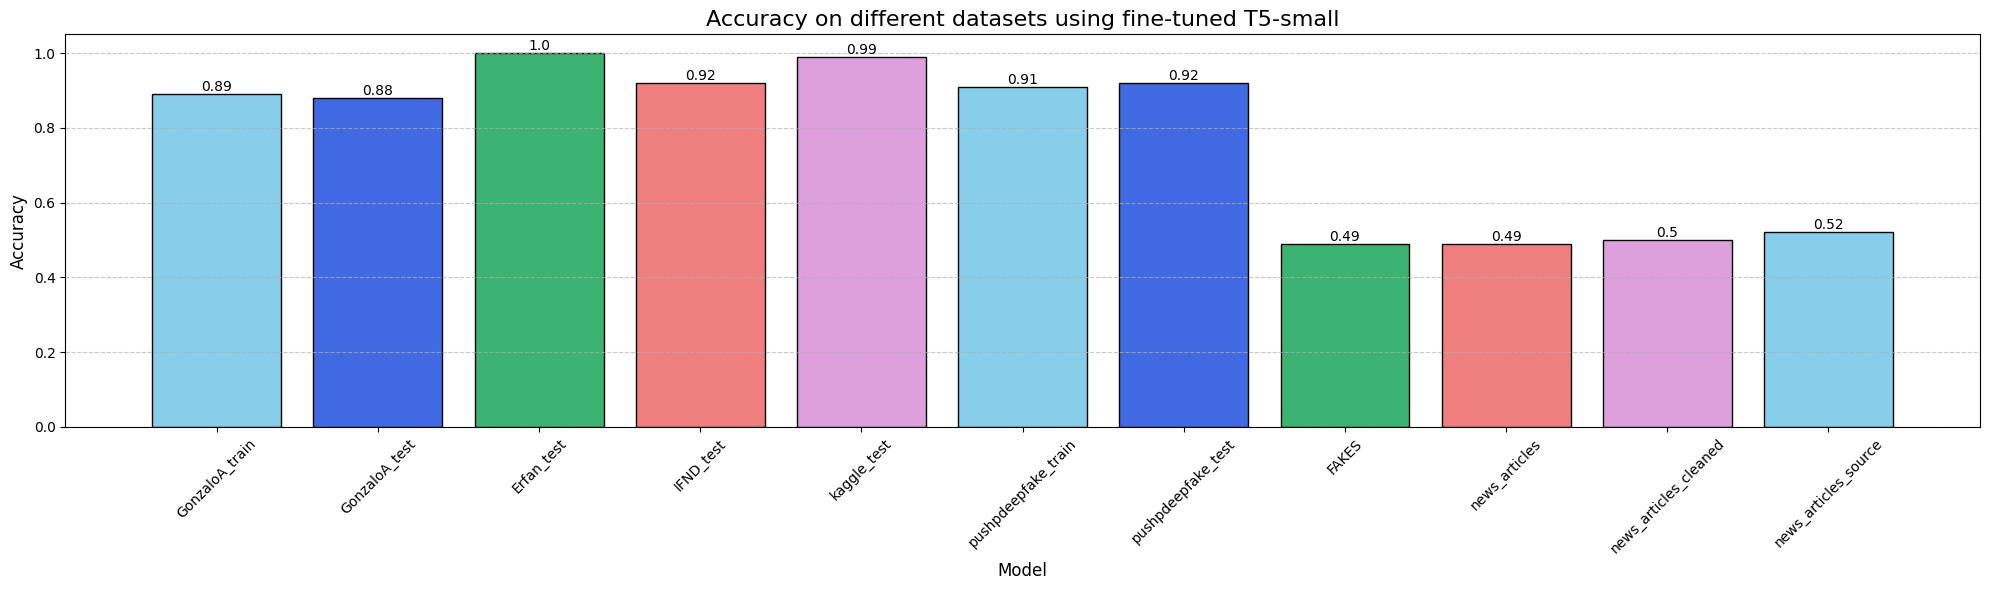

In [52]:
import matplotlib.pyplot as plt

# Model labels
models = [
    "GonzaloA_train",
    "GonzaloA_test",
    "Erfan_test",
    "IFND_test",
    "kaggle_test",
    "pushpdeepfake_train",
    "pushpdeepfake_test",
    "FAKES",
    "news_articles",
    "news_articles_cleaned",
    "news_articles_source",
]

# Accuracy values
accuracies = [
    gonzaloa_train_accuracy,
    gonzaloa_test_accuracy,
    Erfan_test_accuracy,
    IFND_test_accuracy,
    kaggle_test_accuracy,
    pushpdeepfake_train_accuracy,
    pushpdeepfake_test_accuracy,
    FAKES_accuracy,
    news_articles_accuracy,
    news_articles_cleaned_accuracy,
    news_articles_source_accuracy,
]

colors = [
    "skyblue",
    "royalblue",
    "mediumseagreen",
    "lightcoral",
    "plum",
    "skyblue",
    "royalblue",
    "mediumseagreen",
    "lightcoral",
    "plum",
    "skyblue",
]

# Create the bar plot
plt.figure(figsize=(20, 6))
bars = plt.bar(models, accuracies, color=colors, edgecolor="black")

# Adding value labels on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        yval,
        round(yval, 2),
        va="bottom",
        ha="center",
    )

plt.title("Accuracy on different datasets using fine-tuned T5-small", fontsize=16)
plt.ylabel("Accuracy", fontsize=12)
plt.xlabel("Model", fontsize=12)
plt.xticks(rotation=45, fontsize=10)

# Adding a grid
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.tight_layout()
plt.show()